### Code for CAPSTONE Project

In [ ]:
# pip install pyspark
# pip install haversine
# pip install pyarrow

In [5]:
#initialising pyspark
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
spark = SparkSession.builder.master("local").appName('Geodata').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [113]:
#import necessary packages for python
import pandas as pd
import os
from datetime import date, timedelta, time, datetime
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats
import folium
from branca.element import Figure

In [31]:
# import packages for pyspark
import haversine as hs
import pyspark.sql.functions as F
from pyspark.sql.functions import lower,col,udf,substring
from pyspark.sql.functions import regexp_replace,to_timestamp
from pyspark.sql.types import IntegerType

In [9]:
#get working directory as well as list of files in directory
os.chdir(r'C:\Users\user\Desktop\FinalConsolidatedData\Final Summary')
file_list = os.listdir()

In [10]:
#pulling all the files with the address, temp and rain data
Combined_Hourly_Records = pd.DataFrame()
for file in file_list:
    Hourly_Records = pd.read_csv(file)
    Hourly_Records = Hourly_Records[['Long','Lat','Time','Date','temp','rain','address']]
    Hourly_Records['distance'] = list(zip(Hourly_Records.Lat, Hourly_Records.Long))
    Hourly_Records['Haver'] = Hourly_Records['distance'].apply(lambda x:hs.haversine((1.290270, 103.851959),x))
    Hourly_Records['PIE-Hav'] = Hourly_Records['distance'].apply(lambda x:hs.haversine((1.332612,103.81661),x))
    Combined_Hourly_Records = pd.concat([Combined_Hourly_Records, Hourly_Records], axis=0)

In [11]:
# clean duplicates
Combined_Hourly_Records.drop_duplicates(subset=['Long','Lat','Time'],inplace=True)

In [12]:
#Havers for CBD and Distance from expressway
distance_PIE = Combined_Hourly_Records[['address','PIE-Hav']]
distance_PIE = distance_PIE.drop_duplicates(subset="address")
distance_PIE = spark.createDataFrame(distance_PIE)
distance_PIE = distance_PIE.withColumn("address",F.upper(distance_PIE.address))

# convert the PIE file to a pandas dataframe
PIE_KM = distance_PIE.toPandas()

c:\Users\user\miniconda3\envs\obb\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [13]:
# Separating the address and Haversine data
Haver = Combined_Hourly_Records[['address','Haver']]
Haver2 = Haver.drop_duplicates(subset="address")

# Separating the address, temperature, rain and time data
Weather = Combined_Hourly_Records[['address','temp','rain','Time']]
Weather2 = Weather.drop_duplicates(subset=["address","Time"])

In [73]:
Haver_address = Combined_Hourly_Records.drop_duplicates(subset=['address'])[['address','Long','Lat','distance']]
Haver_address = Haver_address.drop_duplicates(subset=['address'])
Haver_address['address']= Haver_address['address'].str.upper()

In [19]:
# Create separate dataframes
SparkDF = spark.createDataFrame(Combined_Hourly_Records)
Haver = spark.createDataFrame(Haver2)
WeatherD = spark.createDataFrame(Weather2)

In [20]:
# Convert all address text to upper case
SparkDF= SparkDF.withColumn("address",F.upper(SparkDF.address))
Haver = Haver.withColumn("address",F.upper(Haver.address))
WeatherD = WeatherD.withColumn("address",F.upper(WeatherD.address))

In [21]:
# get a dataset which groups all the instances of taxi occurence by street name
cols = ['address','Time']
Final = SparkDF.groupby(cols).agg(F.count('distance'))
Final = Final.withColumn("address",F.upper(Final.address))

In [22]:
# convert all time data in string format to time format
Final=Final.withColumn('TimeIndex', col('Time'))
Final=Final.withColumn('TimeIndex', regexp_replace("TimeIndex",'T',' '))
WeatherD=WeatherD.withColumn('TimeIndex', col('Time'))
WeatherD=WeatherD.withColumn('TimeIndex', regexp_replace("TimeIndex",'T',' '))

In [23]:
#creating the datetime and one time period lag interval
Final=Final.withColumn('TimeIndex', to_timestamp(col("TimeIndex"),'yyyy-MM-dd HH:mm'))
WeatherD=WeatherD.withColumn('TimeIndex', to_timestamp(col("TimeIndex"),'yyyy-MM-dd HH:mm'))
Final=Final.withColumn('TimeIndex+1', col("TimeIndex")+ F.expr("INTERVAL 1 HOURS"))

In [24]:
#appending the time lag to the main dataset
Final = Final.withColumn('key',F.concat(F.col('TimeIndex'),F.col('address')))
Final = Final.withColumn('keyplus',F.concat(F.col('TimeIndex+1'),F.col('address')))
WeatherD=WeatherD.withColumn('key',F.concat(F.col('TimeIndex'),F.col('address')))

In [25]:
#Changing some geocode chinese info to english
Final.replace('实龙岗北1道', 'Serangoon North Ave 1','address')

DataFrame[address: string, Time: string, count(distance): bigint, TimeIndex: timestamp, TimeIndex+1: timestamp, key: string, keyplus: string]

### Feature Engineering

In [26]:
# taking part of the time string to get both hour and date
Final= Final.withColumn('Hour', Final.Time.substr(12,2))
Final= Final.withColumn('Date', Final.Time.substr(1,10))

In [27]:
# to join the count info from one hour later to the dataframe as Count1HRLater
Final_1hrLater = Final.select('key','count(distance)')
Final_1hrLater= Final_1hrLater.withColumnRenamed('count(distance)','Count1HRLater')
Final2 = Final.alias('a').join(Final_1hrLater.alias('b'), col("a.keyplus")== col("b.key"), 'left')

### Import Traffic Condition data

In [28]:
# Import Traffic data
os.chdir(r'C:\Users\user\Desktop\FinalConsolidatedData')
Traffic_data = pd.read_csv('Final_Traffic_df_avg.csv',header=1)
Traffic_data=Traffic_data[1:]
Traffic_data= Traffic_data.rename(columns={'Expressway-Direction':'Time'})
Traffic_data['Time'] = pd.to_datetime(Traffic_data['Time'], format ="%Y-%m-%d%H:%M" ) 

In [29]:
# simplify name of all columns
Traffic_data.rename(columns={'AYE-1.0':'AYE1', 'AYE-2.0':'AYE2', 'BKE-1.0':'BKE1', 'BKE-2.0':'BKE2', 'CTE-1.0':'CTE1',
       'CTE-2.0':'CTE2', 'ECP-1.0':'ECP1', 'ECP-2.0':'ECP2', 'KJE-1.0':'KJE1', 'KJE-2.0':'KJE2', 'PIE-1.0':'PIE1',
       'PIE-2.0':'PIE2', 'SLE-1.0':'SLE1', 'SLE-2.0':'SLE2', 'TPE-1.0':'TPE1', 'TPE-2.0':'TPE2'}, inplace=True)

In [30]:
# create dataframe in spark
TrafficDF = spark.createDataFrame(Traffic_data)

c:\Users\user\miniconda3\envs\obb\lib\site-packages\pyspark\sql\pandas\conversion.py:604: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]


In [34]:
# turn type to integer
cols_to_cast = [ 'AYE1', 'AYE2', 'BKE1', 'BKE2', 'CTE1', 'CTE2', 'ECP1', 'ECP2', 'KJE1', 'KJE2', 'PIE1', 'PIE2', 'SLE1',
 'SLE2', 'TPE1', 'TPE2']
df = TrafficDF.select([F.col(c).cast(IntegerType()) if c in cols_to_cast else c for c in TrafficDF.columns])

In [35]:
# joining the Time data to the final dataset
Final3 = Final2.alias("B1").join(df.alias('TDf'), col('B1.TimeIndex') == col('TDf.Time'),'left')

In [36]:
# dropping the Time index
Final4 = Final3.drop('Time','TimeIndex','TimeIndex+1')

In [37]:
# Transiting out of pyspark into python
Final5= Final4.toPandas()
Wea5 = WeatherD.toPandas()
Hav5 = Haver.toPandas()

### Exit pyspark into python

In [38]:
# impute missing value with mean
for column in ['AYE1','AYE2','BKE1','BKE2','CTE1','CTE2','ECP1','ECP2','KJE1','KJE2','PIE1','PIE2','SLE1','SLE2','TPE1','TPE2']:
    Final5[column].fillna(Final5[column].mean(), inplace=True)

In [39]:
# merging the pie data to the final dataset
pie_KM2 = PIE_KM.drop_duplicates(subset=['address'])
Final54 = pd.merge(Final5, pie_KM2, left_on='address', right_on='address', how='left')

In [40]:
# cleaning out duplicates in case of any
Hav6=Hav5.drop_duplicates(subset=['address'])

In [41]:
# merging the distance from cbd to the main dataset
Final6 = pd.merge(Final54, Hav6, left_on='address', right_on='address', how='left')

In [42]:
Final6.set_index('key')
Wea5.set_index('key')

,address,temp,rain,Time,TimeIndex
key,,,,,
2022-11-23 00:00:00CHANGI ROAD,CHANGI ROAD,26.1,0.0,2022-11-23T00:00,2022-11-23 00:00:00
2022-11-23 00:00:00PROPOSED HIGHWAY,PROPOSED HIGHWAY,26.1,0.0,2022-11-23T00:00,2022-11-23 00:00:00
2022-11-23 00:00:00HOOT KIAM ROAD,HOOT KIAM ROAD,26.7,0.0,2022-11-23T00:00,2022-11-23 00:00:00
2022-11-23 00:00:00UPPER THOMSON ROAD,UPPER THOMSON ROAD,26.0,0.0,2022-11-23T00:00,2022-11-23 00:00:00
2022-11-23 00:00:00BAYFRONT AVENUE,BAYFRONT AVENUE,26.7,0.0,2022-11-23T00:00,2022-11-23 00:00:00
...,...,...,...,...,...
2022-11-29 04:00:00BUKIT BATOK WEST AVENUE 8,BUKIT BATOK WEST AVENUE 8,29.3,0.0,2022-11-29T04:00,2022-11-29 04:00:00
2022-11-29 05:00:00SENNETT TERRACE,SENNETT TERRACE,29.8,0.0,2022-11-29T05:00,2022-11-29 05:00:00
2022-11-29 04:00:00WOODLANDS STREET 81,WOODLANDS STREET 81,29.3,0.0,2022-11-29T04:00,2022-11-29 04:00:00


In [43]:
Final7 = pd.merge(Final6, Wea5, left_index=True, right_index=True, how='left')

## Feature Engineering

In [44]:
# Creating the hour and day features using date time
Final7['Day']=pd.to_datetime(Final7['Date']).dt.day_of_week
Final7['Hour'] = Final7['Hour'].astype(int)

In [45]:
# Creating the other shift, peak hour and midnight surcharge features
Final7['Shift'] = [1 if (x > 15 and x <18) else 0 for x in Final7['Hour']]
peak = [6,7,8,9,10,18,19,21,22,23,24]
Final7['Peak_period'] = [1 if x in peak else 0 for x in Final7['Hour']]
Final7['Midnight'] = [1 if x in range(0,7) else 0 for x in Final7['Hour']]

In [46]:
# creating quartiles for temperature and rain
Final7['temp_q'] = pd.cut(Final7['temp'],4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
Final7['rain_q'] = pd.cut(Final7['rain'],4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

In [47]:
# creating binary classification for CBD/ Non CBD
Final7['CBD'] = [1 if x < 4 else 2 for x in Final7['Haver']]
Final7['CBD1'] = [1 if x < 4 else 0 for x in Final7['Haver']]

## EDA

In [48]:
#Excluding expressway
Final_exExpressway = Final7[Final7["address_x"].str.contains("EXPRESSWAY") == False]
Final_exExpressway = Final_exExpressway[Final_exExpressway["address_x"]!= "EAST COAST PARKWAY"]

In [49]:
# dropna in case of any
Final_File = Final_exExpressway.dropna(axis=0)

#### Getting the average number of taxis (Day of Week) **

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

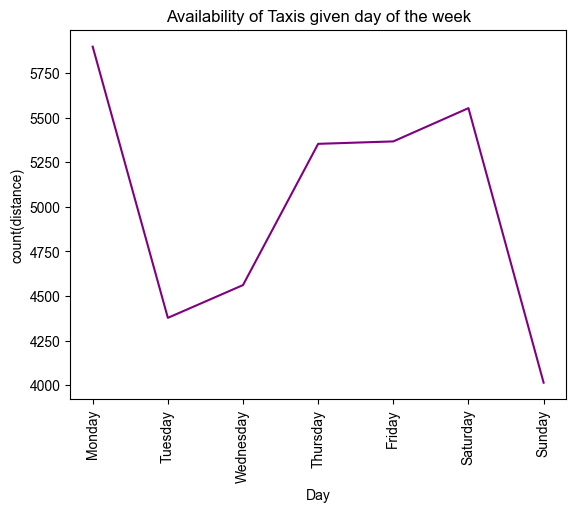

In [50]:
# pivot according to date, day and CBD1 to get the total numbre of taxis everyday
Top_Street_by_date_day = pd.pivot_table(Final_exExpressway, index=['Date','Day','CBD1'], values=['count(distance)'],aggfunc=np.sum)
# pivot the data to get average of day of week
Top_Street_by_day = pd.pivot_table(Top_Street_by_date_day, index=['Day'], values=['count(distance)'],aggfunc=np.mean)

fig, ax = plt.subplots()
#plot the average number of taxi over the course of the week
fig=sns.lineplot(x='Day',y='count(distance)',data=Top_Street_by_day, color='purple').set(title='Availability of Taxis given day of the week')
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
# Set the tick labels to order list
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)
# Set the size of the seaborn figure
sns.set(rc={"figure.figsize":(8,6)})
# rotate the xticks
plt.xticks(rotation=90)

#### Getting the average number of taxis (Time of Day) **

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

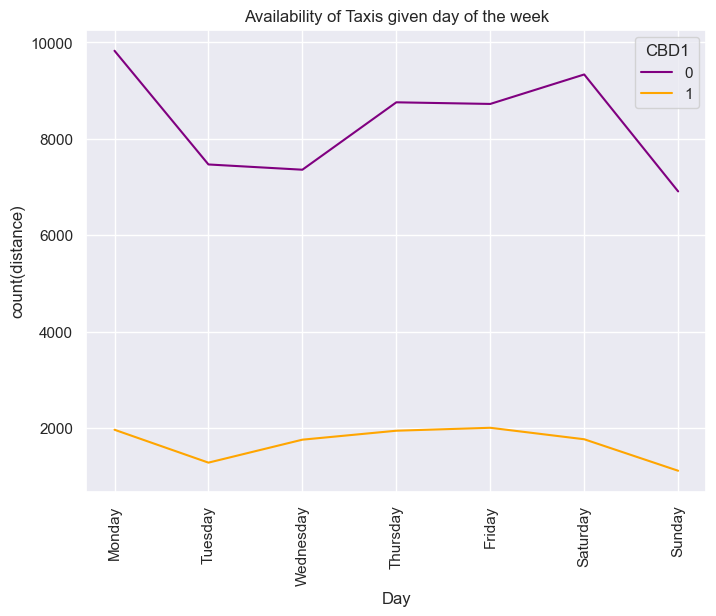

In [51]:
# get average taxis per day but split it according to CBD or no CBD
Top_Street_by_day = pd.pivot_table(Top_Street_by_date_day, index=['Day','CBD1'], values=['count(distance)'],aggfunc=np.mean)
fig, ax = plt.subplots()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
fig=sns.lineplot(x='Day',y='count(distance)',hue='CBD1',data=Top_Street_by_day, palette=['purple','orange']).set(title='Availability of Taxis given day of the week')
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)
plt.xticks(rotation=90)

(array([-5.,  0.,  5., 10., 15., 20., 25.]),
 [Text(-5.0, 0, '−5'),
  Text(0.0, 0, '0'),
  Text(5.0, 0, '5'),
  Text(10.0, 0, '10'),
  Text(15.0, 0, '15'),
  Text(20.0, 0, '20'),
  Text(25.0, 0, '25')])

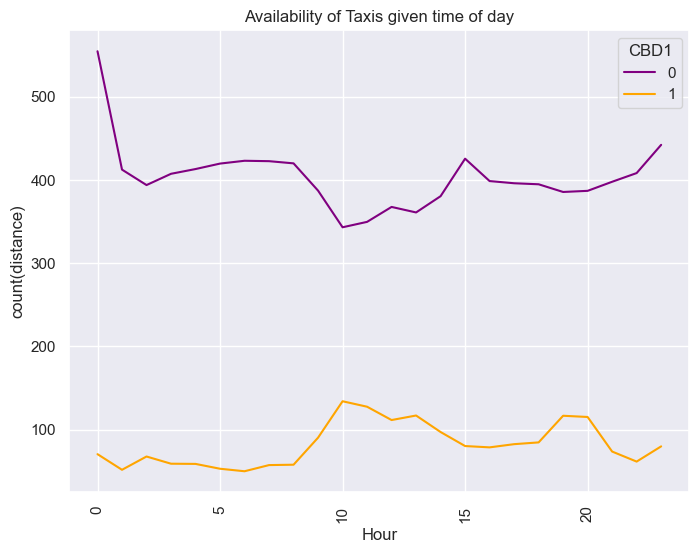

In [52]:
# to get the time of day dimension
Top_Street_by_date_hour = pd.pivot_table(Final_exExpressway, index=['Date','Hour','CBD1'], values=['count(distance)'],aggfunc=np.sum)
Top_Street_by_hour = pd.pivot_table(Top_Street_by_date_hour, index=['Hour','CBD1'], values=['count(distance)'],aggfunc=np.mean)
fig, ax = plt.subplots()
fig=sns.lineplot(x='Hour',y='count(distance)',hue='CBD1',data=Top_Street_by_hour, palette=['purple','orange']).set(title='Availability of Taxis given time of day')
plt.xticks(rotation=90)

In [ ]:
Final_exExpressway['CBD_string'] = ['CBD' if x == 1 else 'Non-CBD' for x in Final_exExpressway['CBD1']]

C:\Users\user\AppData\Local\Temp\ipykernel_7264\832955827.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PIE['CBD+Jam'] = PIE['CBD']* PIE['PIE1_jam']
C:\Users\user\AppData\Local\Temp\ipykernel_7264\832955827.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PIE['CBD+Jam_map'] = PIE['CBD+Jam'].map({3:'CBD Jam', 4:'CBD No Jam', 6:'Non CBD Jam',  8:'Non CBD No Jam'})


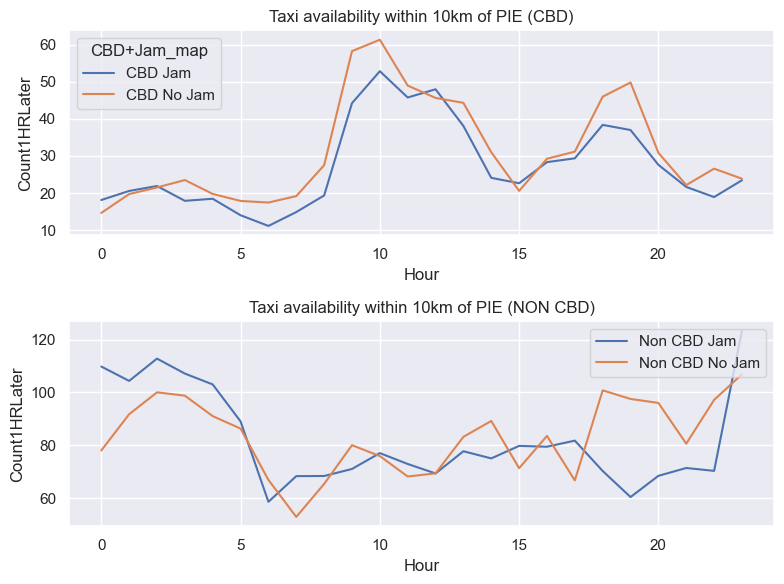

In [115]:
# Calculate Z score for the timing
Final_exExpressway['PIE1_z'] = stats.zscore(Final_exExpressway['PIE1'])
Final_exExpressway['PIE2_z'] = stats.zscore(Final_exExpressway['PIE2'])

# Create Jam Binary variable
Final_exExpressway['PIE1_jam'] = [3 if x >0 else 4 for x in Final_exExpressway['PIE1_z']]
Final_exExpressway['PIE2_jam'] = [3 if x >0 else 4 for x in Final_exExpressway['PIE2_z']]

# create filter for areas within 10km of PIE
PIE = Final_exExpressway[Final_exExpressway['PIE-Hav']<= 10]

# create CBD Jam Indicator
PIE['CBD+Jam'] = PIE['CBD']* PIE['PIE1_jam']
PIE['CBD+Jam_map'] = PIE['CBD+Jam'].map({3:'CBD Jam', 4:'CBD No Jam', 6:'Non CBD Jam',  8:'Non CBD No Jam'})

# Sum of available taxis for every hour of every day
PIE_Grouped = PIE.groupby(['PIE1_jam','CBD+Jam','CBD+Jam_map','Date','Hour'])['Count1HRLater'].sum()
PIE_Grouped=PIE_Grouped.reset_index()

# Average of cumulative taxis for every hour
PIE_Grouped_hour = PIE_Grouped.groupby(['Hour','CBD+Jam','CBD+Jam_map'])['Count1HRLater'].mean()
PIE_Grouped_hour=PIE_Grouped_hour.reset_index()

# Create two subplots
fig, axs = plt.subplots(2,1)
g1=sns.lineplot(x='Hour', y = 'Count1HRLater', hue='CBD+Jam_map', data= PIE_Grouped_hour[PIE_Grouped_hour['CBD+Jam']<5], ax=axs[0]).set(title='Taxi availability within 10km of PIE (CBD)')
g2=sns.lineplot(x='Hour', y = 'Count1HRLater', hue='CBD+Jam_map', data= PIE_Grouped_hour[PIE_Grouped_hour['CBD+Jam']>5], ax=axs[1]).set(title='Taxi availability within 10km of PIE (NON CBD)')
plt.tight_layout()
sns.set(rc={"figure.figsize":(6,6)})
plt.legend(loc='upper right')

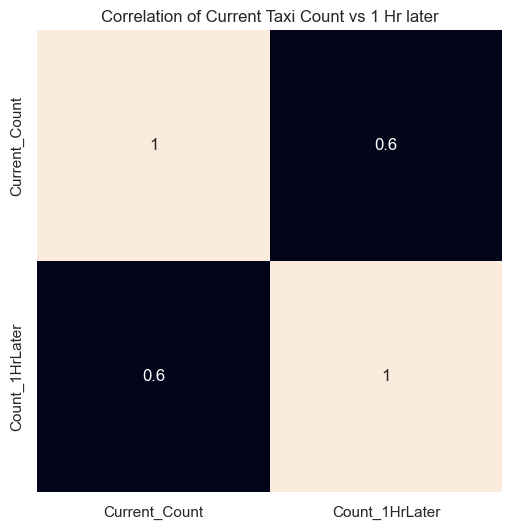

In [122]:
# create the heatmap with the correlation of current vs 1hr later
Final_exExpressway['Current_Count']= Final_exExpressway['count(distance)']
Final_exExpressway['Count_1HrLater']= Final_exExpressway['Count1HRLater']
sns.heatmap(Final_exExpressway[['Current_Count','Count_1HrLater']].corr(), annot=True, cbar=False).set(title='Correlation of Current Taxi Count vs 1 Hr later')
sns.set(rc={"figure.figsize":(6,6)})

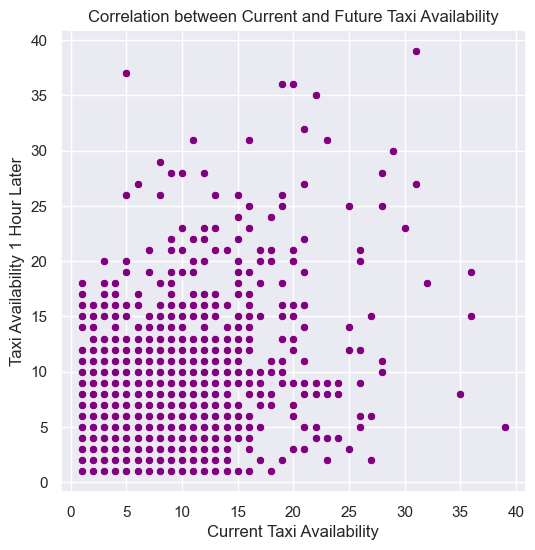

In [123]:
# create scatter of current vs 1hr later
sns.scatterplot(x='count(distance)', y = 'Count1HRLater', data= Final_exExpressway, color='purple')
plt.xlabel('Current Taxi Availability')
plt.ylabel('Taxi Availability 1 Hour Later')
plt.title('Correlation between Current and Future Taxi Availability')
sns.set(rc={"figure.figsize":(6,6)})

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Monday'),
  Text(1, 0, 'Tuesday'),
  Text(2, 0, 'Wednesday'),
  Text(3, 0, 'Thursday'),
  Text(4, 0, 'Friday'),
  Text(5, 0, 'Saturday'),
  Text(6, 0, 'Sunday')])

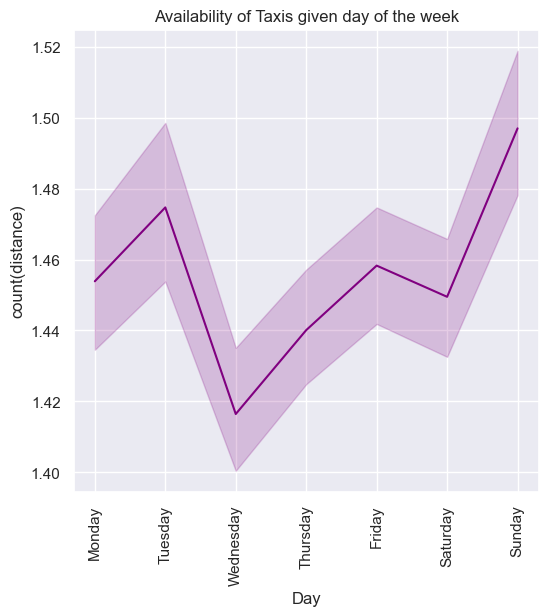

In [128]:
# to plot availability of taxi with day of the week
fig, ax = plt.subplots()
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"]
fig=sns.lineplot(y='count(distance)', x='Day', data=Final_exExpressway, color='purple').set(title='Availability of Taxis given day of the week')
sns.set(rc={"figure.figsize":(6,6)})
ax.set_xticks(range(len(order)))
ax.set_xticklabels(order)
plt.xticks(rotation=90)

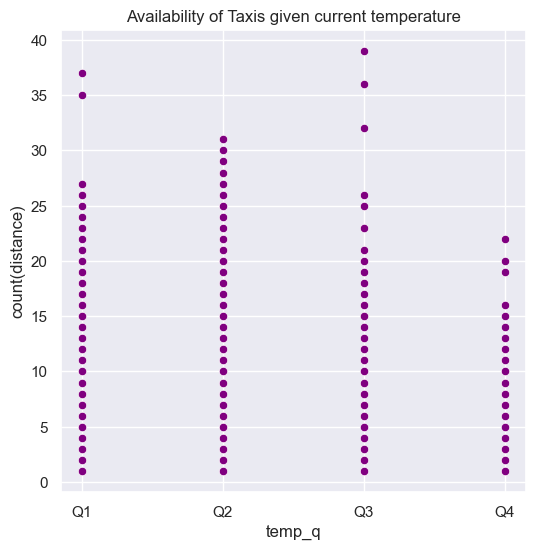

In [126]:
# checking if taxi availability is affected by temperature
sns.scatterplot(y='count(distance)', x='temp_q', data=Final_exExpressway, color='purple').set(title='Availability of Taxis given current temperature')
sns.set(rc={"figure.figsize":(6,6)})

[Text(0.5, 1.0, 'Availability of Taxis given rain')]

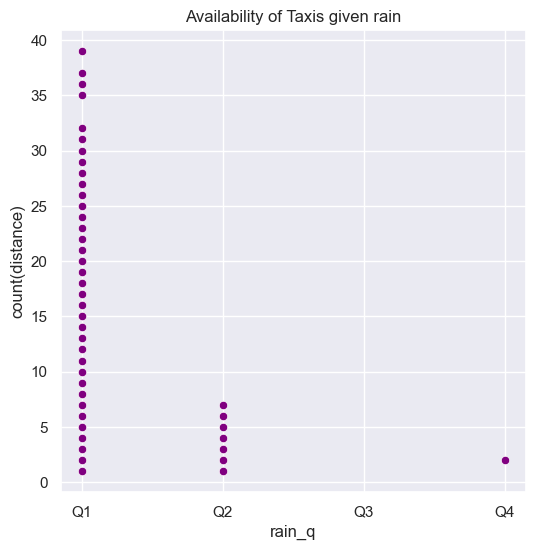

In [127]:
# checking if taxi availability is affected by rain
sns.scatterplot(y='count(distance)', x='rain_q', data=Final_exExpressway, color='purple').set(title='Availability of Taxis given rain')

## Top address

Text(0.5, 1.0, 'Street with the most taxis in the day')

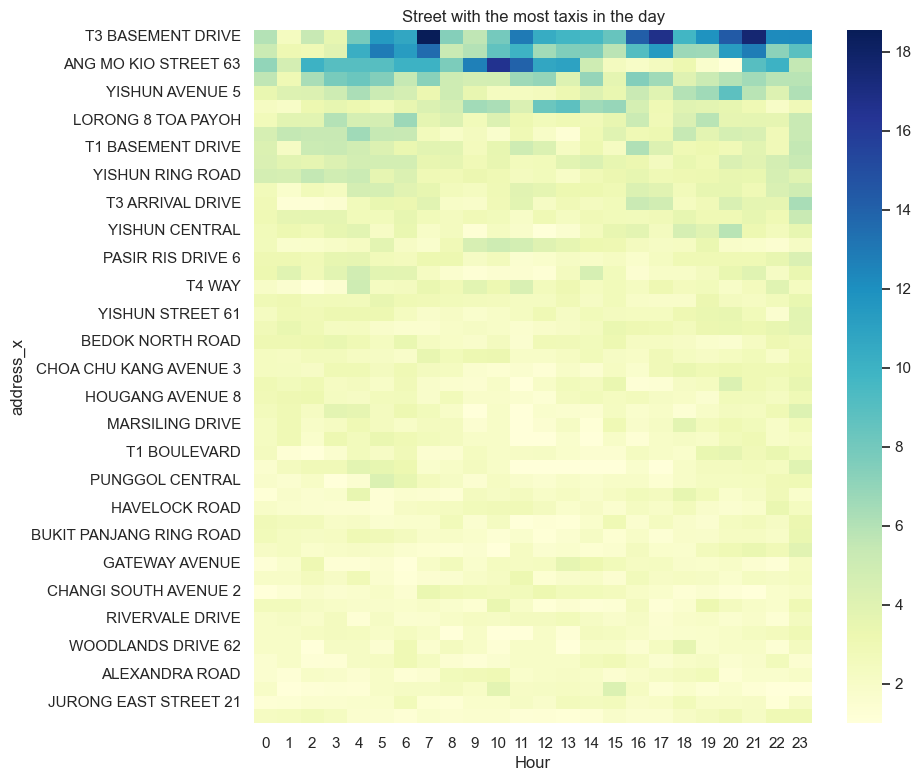

In [111]:
# to get the top 50 streets that have the most taxi availability
Top_Street_by_date = pd.pivot_table(Final_exExpressway, index=['Time','Hour','address_x'], values=['Count1HRLater'])
Top_Street_by_date = Top_Street_by_date.sort_values(by='Count1HRLater', ascending=False)
Top_Street_by_date.reset_index(inplace=True)
Top_street_df= Top_Street_by_date.pivot_table(index='address_x', columns='Hour', values='Count1HRLater', aggfunc=np.mean)
Top_street_df.dropna(inplace=True)
original_hours = Top_street_df.columns
Top_street_df['total'] = Top_street_df.sum(axis=1) 
Top_street_df = Top_street_df.sort_values(by='total', ascending=False)
plt.figure(figsize = (9,9))
sns.heatmap(Top_street_df[original_hours].head(50),cmap="YlGnBu")
plt.title('Street with the most taxis in the day')

## Folium map for Whole Singapore map

In [109]:
# Draw circles on the map where there taxis appear the most
Top_street_df.reset_index(inplace=True)
FoliumVisual = pd.merge(Top_street_df, Haver_address, left_on='address_x', right_on='address', how='left')
FoliumVisual50= FoliumVisual.sort_values(by=['total'], ascending=False)
fig3=Figure(width=550,height=350)
m3=folium.Map(location=[1.36270, 103.831959],tiles='openstreetmap', zoom_start=12)
for i in range(len(FoliumVisual50.head(50))):
    folium.CircleMarker( location=[FoliumVisual['Lat'][i],FoliumVisual['Long'][i]],radius=2,popup=None).add_to(m3)
m3

# Pre Modelling work

In [142]:
# get all necessary modelling imports
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
import haversine as hs
from sklearn.metrics import confusion_matrix as cm, precision_score

In [163]:
# suppress all warnings especially Convergence warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

In [143]:
# label encode both the address and rain columns
le = LabelEncoder()
Final_exExpressway['street_label'] = le.fit_transform(Final_exExpressway['address_x'])
Final_exExpressway['Rain_q'] = le.fit_transform(Final_exExpressway['rain_q'])

In [144]:
# drop columns where there are no values for count of taxis one hour later
Final_exExpressway2 = Final_exExpressway.dropna(subset=['Count1HRLater'])

# create binary indicator of whether taxi will be available one hour later
Final_exExpressway2['Available/Not'] = [1 if x >=2 else 0 for x in Final_exExpressway2['Count1HRLater']]

C:\Users\user\AppData\Local\Temp\ipykernel_7264\2489580580.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Final_exExpressway2['Available/Not'] = [1 if x >=2 else 0 for x in Final_exExpressway2['Count1HRLater']]


In [145]:
# define Y and X
Y = Final_exExpressway2['Available/Not']
X=Final_exExpressway2[['street_label', 'count(distance)','Day', 'Hour',
       'Shift', 'Peak_period', 'Midnight', 'Rain_q', 'CBD1','PIE1_jam', 'PIE2_jam']]

In [146]:
# Train test Split
X_train,X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33,stratify=Y)

# Initiate smote and resample the train data
sm = SMOTE(random_state = 33)
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

# initiate polynomial features
poly = PolynomialFeatures()
poly.fit(X_train_new)
X_poly = poly.transform(X_train_new)

# scale the train data with min max
minmax = MinMaxScaler()
minmax.fit(X_poly)
X_train_scale = minmax.transform(X_poly)

# polynomial and scale the test data as well
X_poly_test = poly.transform(X_test)
X_test_scale = minmax.transform(X_poly_test)

#### Create function for various models to generate precision score given threshold

In [180]:
## Create a function to run the different models with a series of thresholds
def generate_threshold(Model,X_train, y_train, x_test, y_test, prob_set = np.linspace(0.1,1,20)):
    prob_list = []
    precision_list = []
    tp_list = []
    fp_list = []
    for count, prob in enumerate(prob_set):
        precision, tp, fp, y_test, y_pred = Model(X_train, y_train, x_test, y_test, prob)
        precision_list.append(precision)
        prob_list.append(prob)
        tp_list.append(tp)
        fp_list.append(fp)
    Summary = pd.DataFrame(zip(prob_list, precision_list, fp_list, tp_list), columns=['Threshold','Precision','False Positive','True Positive'])
    return Summary

### Logistic Regression

In [176]:
## Logistic Regression
def Model(X_train,y_train,X_test,y_test,n):
  LR = LogisticRegression()
  LR.fit(X_train,y_train)
  y_hat = LR.predict_proba(X_test)
  y_hat = y_hat[:, 1]
  y_pred = [1 if x >=n else 0 for x in y_hat]
  tn, fp, fn, tp = cm(y_test,y_pred).ravel()
  return precision_score(y_test, y_pred), tp, fp, y_test, y_pred

Text(0.5, 1.0, 'Confusion Matrix')

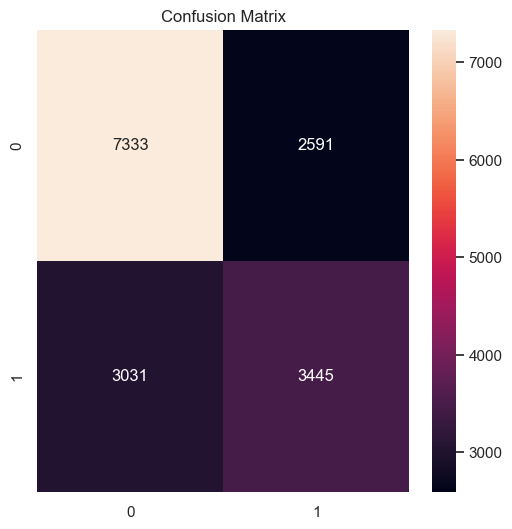

In [177]:
# creating a confusion matrix from the Logistic Regression model results
prec_score,tp, fp, y_test, y_pred = Model(X_train_scale, y_train_new, X_test_scale, y_test, 0.5)
sns.heatmap(cm(y_test,y_pred),fmt='g', annot=True).set_title('Confusion Matrix')

In [182]:
Sum_DF = generate_threshold(Model,X_train_scale, y_train_new, X_test_scale, y_test, prob_set = np.linspace(0.1,1,20))

### Random Forest Classifier

In [192]:
# defining random forest classifier as model 2
def Model2(X_train,y_train,X_test,y_test,n):
  RFClassifier = RandomForestClassifier()
  param_grid = {
    'n_estimators': [100,200,300],
    'max_features' : ['auto','log2'],
    'max_depth' : [4,5,6,7],
    'criterion' : ['gini','entropy']
    }
  CV_randomforest = HalvingRandomSearchCV(RFClassifier, param_grid, cv=20, n_jobs=-1)
  CV_randomforest.fit(X_train, y_train)
  y_hat = CV_randomforest.predict_proba(X_test)
  y_hat = y_hat[:, 1]
  y_pred = [1 if x >=n else 0 for x in y_hat]
  tn, fp, fn, tp = cm(y_test,y_pred).ravel()
  return precision_score(y_test, y_pred), tp, fp, y_test, y_pred


Text(0.5, 1.0, 'Confusion Matrix')

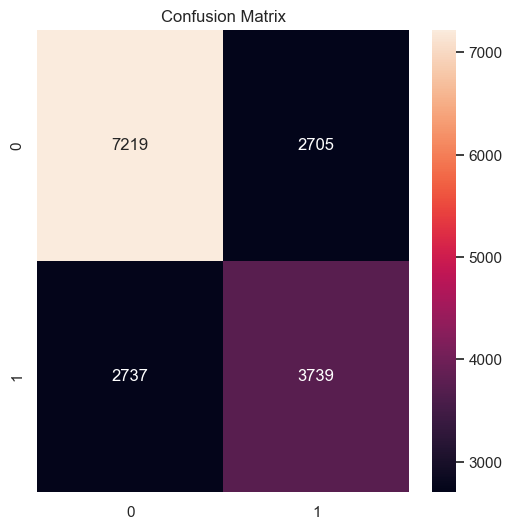

In [173]:
# creating the confusiong matrix for Random Forest Classifier using the default threshold of 0.5
prec_score, y_test, y_pred = Model2(X_train_scale, y_train_new, X_test_scale, y_test, 0.5)
sns.heatmap(cm(y_test,y_pred),fmt='g', annot=True).set_title('Confusion Matrix')

In [ ]:
Sum_DF = generate_threshold(Model2,X_train_scale, y_train_new, X_test_scale, y_test, prob_set = np.linspace(0.1,1,20))

## AdaBoost

In [197]:
# defining Adaboost as the third model
def Model3(X_train,y_train,X_test,y_test,n):
  clf = AdaBoostClassifier(algorithm='SAMME.R')
  grid = dict()
  grid['n_estimators'] =np.linspace(50,500,20,dtype=int)
  grid['learning_rate'] = [0.01, 0.1, 1.0]
# define the evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)
# define the grid search procedure
  grid_search = HalvingRandomSearchCV(clf, grid, n_jobs=-1, cv=cv, verbose=1)
  grid_search.fit(X_train, y_train)
  y_hat = grid_search.predict_proba(X_test)
  y_hat = y_hat[:, 1]
  y_pred = [1 if x >=n else 0 for x in y_hat]
  tn, fp, fn, tp = cm(y_test,y_pred).ravel()
  return precision_score(y_test, y_pred), tp, fp, y_test, y_pred


n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 7
min_resources_: 24
max_resources_: 40296
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 60
n_resources: 24
Fitting 6 folds for each of 60 candidates, totalling 360 fits
----------
iter: 1
n_candidates: 20
n_resources: 72
Fitting 6 folds for each of 20 candidates, totalling 120 fits
----------
iter: 2
n_candidates: 7
n_resources: 216
Fitting 6 folds for each of 7 candidates, totalling 42 fits
----------
iter: 3
n_candidates: 3
n_resources: 648
Fitting 6 folds for each of 3 candidates, totalling 18 fits


Text(0.5, 1.0, 'Confusion Matrix')

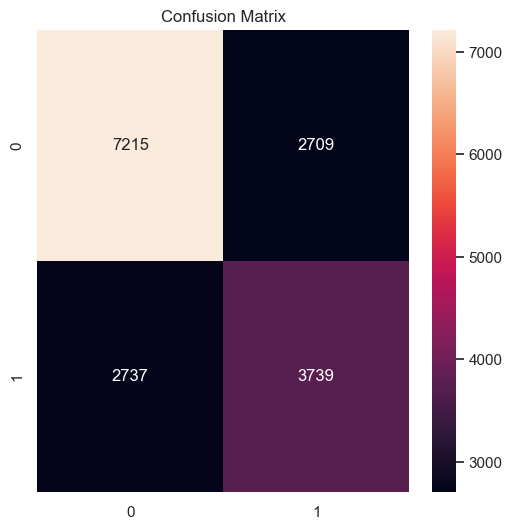

In [198]:
# running a confusion matrix using prediction from adaboost
prec_score,tp, fp, y_test, y_pred = Model3(X_train_scale, y_train_new, X_test_scale, y_test, 0.5)
sns.heatmap(cm(y_test,y_pred),fmt='g', annot=True).set_title('Confusion Matrix')

In [ ]:
Sum_DF = generate_threshold(Model3,X_train_scale, y_train_new, X_test_scale, y_test, prob_set = np.linspace(0.1,1,20))

## Scenarios

### North Bridge Road Example

In [246]:
#defining a particular road as an example
street = 'NORTH BRIDGE ROAD'
Day_entry = 1
Hour_entry = 20
walking_distance = 0.2

In [247]:
fig4=Figure(width=550,height=350)
m4=folium.Map(location=[1.292024, 103.850989],tiles='cartodbpositron',zoom_start=30)
folium.CircleMarker( location=[1.292024,103.850989],radius=5,color='purple').add_to(m4)
fig4.add_child(m4)

Text(0, 0.5, 'Taxi Availability')

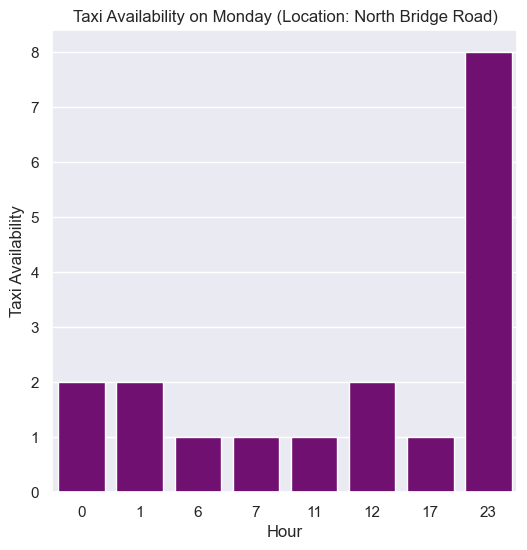

In [248]:
# Get the historic availability of taxis given the timing and rain conditions
Query_df2 = Final_File[(Final_File['address_x'].str.contains(street))& (Final_File['Day']==Day_entry) & (Final_File['rain_q']=='Q1')]
ax = sns.barplot(x= 'Hour', y ='count(distance)', data=Query_df2,color='purple').set(title='Taxi Availability on Monday (Location: North Bridge Road)')
plt.ylabel('Taxi Availability')

In [249]:
Query_df = Final_File[(Final_File['Day']==Day_entry) & (Final_File['rain_q']=='Q1')]

#Find out the latlong of the place of interest
Query_address = Haver_address[Haver_address['address']==street]['distance'].values[0]

# create column with distance from Query_address
Haver_address['far_near'] = Haver_address['distance'].apply(lambda x:hs.haversine(Query_address,x))

# create a list of possible places which commuter can walk to get their ride
Short_list = Haver_address[Haver_address['far_near']<walking_distance]['address'].to_list()

In [250]:
# creating test dataframe with series of assumptions
Test_df = pd.DataFrame()
Test_df['street_label'] = Final_exExpressway[Final_exExpressway['address_x'].isin(Short_list)]['street_label']
Test_df['count(distance)'] = 1

Test_df['Day'] = Day_entry
Test_df['Hour'] = Hour_entry

Test_df['Shift'] = [1 if (x > 15 and x <18) else 0 for x in Test_df['Hour']]
peak = [6,7,8,9,10,18,19,21,22,23,24]
Test_df['Peak_period'] = [1 if x in peak else 0 for x in Test_df['Hour']]
Test_df['Midnight'] = [1 if x in range(0,7) else 0 for x in Test_df['Hour']]
Test_df['Rain_q'] = 1
Test_df['CBD1'] = 1
Test_df['PIE1_jam']= 0
Test_df['PIE2_jam']=0

In [251]:
#poly and minmax transform the testing dataframe
Test_poly = poly.transform(Test_df)
Test_Scale = minmax.transform(Test_poly)

In [252]:
# Using a version of the Random Forest Classifier to predict where the cab might be
RFClassifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [100,200,300],
    'max_features' : ['auto','log2'],
    'max_depth' : [4,5,6,7],
    'criterion' : ['gini','entropy']
    }

In [253]:
#Using halfgrid search to get the final tuned model with prediction
CV_randomforest = HalvingRandomSearchCV(RFClassifier, param_grid, cv=20, n_jobs=-1)
CV_randomforest.fit(X_train_scale, y_train_new)
y_hat = CV_randomforest.predict_proba(Test_Scale)
y_hat_star = y_hat[:, 1]

In [261]:
# Will need more data to generate robust thresholds for every street
y_pred_star = [1 if x >=0.385 else 0 for x in y_hat_star]
print(np.unique(np.array(y_pred_star)))

[0 1]


In [262]:
# adding the predicted column to the test dataframe. 
Test_df2 = Test_df.copy()
Test_df2['predicted']=y_pred_star
Test_df2['predicted'].unique()
Results = Test_df2[Test_df2['predicted']==1]['street_label'].unique()

In [263]:
# Getting the list of locations which are predicted to have Taxis
Taxi = Final_exExpressway[Final_exExpressway['street_label'].isin(Results)]['address_x'].unique()
Taxi_df= Haver_address[Haver_address['address'].isin(Taxi)]
Taxi_df.reset_index(inplace=True)

In [264]:
# plotting all the other locations on the same map
fig4=Figure(width=550,height=350)
m4=folium.Map(location=[1.292024, 103.850989],tiles='cartodbpositron',zoom_start=30,color='purple')
folium.CircleMarker( location=[1.292024,103.850989],radius=5,color='purple').add_to(m4)
for i in range(len(Taxi_df)):
    folium.CircleMarker( location=[Taxi_df['Lat'][i],Taxi_df['Long'][i]],radius=2,popup=None,color='orange').add_to(m4)
m4